

# Super- and subradiance of two dipoles

In this example we look at two interacting identical atomic dipoles and their radiation properties at small separations.
The time evolution of the atoms is governed by the master equation $\dot{\rho} = -i [H,\rho] + \mathcal{L}[\rho]$. The Hamiltonian in a frame rotating at the atomic transition frequency $\omega_0$ reads

$ H  = \sum_{i\neq j} \Omega_{ij} \sigma^-_i \sigma^+_j$,

and the Lindblad operator is

$\mathcal{L}[\rho] = \frac{1}{2}\sum_{i,j}\Gamma_{ij}(2\sigma^-_i\rho \sigma^+_j - \sigma^+_i\sigma^-_j \rho - \rho \sigma^+_i \sigma^-_j)$.


Here the symmetric collective decay and dipole interaction matrices $\Gamma_{ij}$ and $\Omega_{ij}$ are related to the imaginary and real part of Green's tensor in free space, which upon acting on an oscillating unit dipole is given by

$G(\vec{r},\omega_0)\cdot \hat{\mu} = \frac{e^{ik_0 r}}{4\pi r}\big[(\hat{r} \times \hat{\mu}) \times \hat{r} + (\frac{1}{k_0^2 r^2}-\frac{i}{k_0 r})(3\hat{r}(\hat{r}\cdot \hat{\mu})-\hat{\mu})\big]$

and we import and use via the CollectiveSpins.jl package.

where $\hat{\mu}$, $\hat{r}$ and $k_0 =\omega_0/c$ are the dipole orientation, the position unit vector and the wavenumber associated with the atomic transition respectively. In the single excitation manifold we ignore the first term in the Lindblad operator and rewrite the system as an effective Hamiltonian, which reads

$H_{eff} = \sum_{ij}(\Omega_{ij}-i \frac{1}{2}\Gamma_{ij}) \sigma^+_i \sigma^-_j$

In the single excitation manifold the effective Hamiltonian has two eigenstates $|\psi \rangle = (|e\rangle |g\rangle \pm |g\rangle |e\rangle)/\sqrt{2}$, which are symmetric and antisymmetric superposition states with decay rates $\Gamma_0 \pm \Gamma_{12}$, where $\Gamma_0 = |\vec{\mu}|k_0^3/3\pi\hbar \epsilon_0$ is the decay rate of a single emitter and in the following we look at their radiation and decay properties.

First we load the necessary libraries.

In [42]:
using QuantumOptics, PyPlot, CollectiveSpins

Then, we define the parameters, geometry and basis for two two-level atoms.

In [43]:
N = 2
Γ0 = 1.0 # Decay rate
d = 0.1 # Distance between atoms
k0 = 2π # corresponds to λ=1

# Dipole orientation and Positions
pos = [[-d/2,0.0,0.0],[d/2,0.0,0.0]]
dips = [[1.0,0.0,0.0] for i=1:N];

# Basis and operators in the single-excitation basis
b = NLevelBasis(N)
sm(i) = transition(b, N, i)
sp(i) = transition(b, i, N);
σ = sm.([1:N;])
σp = sp.([1:N;]);

Next we use the functions $\Omega(i,j)$ and $\Gamma(i,j)$ from CollectiveSpins.jl to generate the effective Hamiltonian and diagonalize it.

In [44]:
Ω(i,j) = Omega_ij(pos[i],pos[j],dips[i],dips[j],k0)
Γ(i,j) = Gamma_ij(pos[i],pos[j],dips[i],dips[j],k0)
Heff = sum((Ω(i,j)-1im*Γ(i,j)*0.5)*sp(i)*sm(j) for i=1:N,j=1:N)
λ = eigenstates(dense(Heff))

([-14.2511, 14.2511], Ket{NLevelBasis,Array{Complex{Float64},1}}[Ket(dim=2)
  basis: NLevel(N=2)
 -0.707107+0.0im
 -0.707107+0.0im, Ket(dim=2)
  basis: NLevel(N=2)
 -0.707107+0.0im
  0.707107+0.0im])

To plot the quantum field intensity we first calculate the output field $E^+(\vec{r}) = \frac{|\vec{\mu}|k_0^2}{\epsilon_0}\sum_i G(\vec{r}-\vec{r_i},\omega_0)\cdot \vec{\mu}_i\sigma^-_i$ of the system and then the intensity $I(\vec{r}) = \langle E^+ E^- \rangle$ at a point $\vec{r}$.

In [45]:
function Ep(r)
    out = [0*σ[1] for i=1:3]
    for i=1:N
        G_ = GreenTensor(r - pos[i], k0)
        Gpi = (G_ * dips[i])
        @inbounds for j=1:3
            out[j].data .+= σ[i].data .* Gpi[j]
        end
    end
    out
end

function Intensity(r)
    E = Ep(r)
    sum(dagger(e)*e for e=E)
end

I_exp(r, ψ) = real(expect(Intensity(r), ψ));

Now we define a grid and plot the radiation patterns of the symmetric and antisymmetric eigenstates for the two atoms which are separated by $d = \lambda_0/10$. We see that the intensities of the radiation fields between the superradiant and the subradiant states differ by two orders of magnitude.

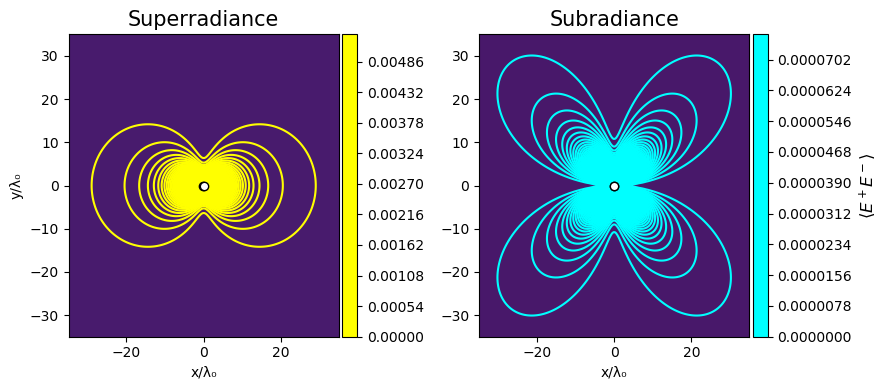

In [46]:
xmin = -35  ; xmax = 35 # Define grid
x = collect(range(-xmax, stop=xmax, length=200))
y = collect(range(-xmax, stop=xmax, length=200))
z = 1.5
grid = [[x1, y1, z1] for x1=x, y1=y, z1=z];

# Compute
I_profile_1 = [I_exp(gr, λ[2][1]) for gr=grid];
I_profile_2 = [I_exp(gr, λ[2][2]) for gr=grid];

figure(figsize=(9, 4))
subplot(121)
contour(y, x, I_profile_1, 500,colors="yellow")
colorbar(pad = 0.01)
contourf(y, x, I_profile_1,cmap="viridis")
plot([-d/2,d/2], [0.0,0.0],"wo",markeredgecolor="k")
title("Superradiance",size=15)
xlabel("x/λ₀")
ylabel("y/λ₀")

subplot(122)
contour(y, x, I_profile_2, 500,colors="cyan")
cb = colorbar(pad = 0.01)
cb.set_label(L"\langle E^+ E^-\rangle",fontsize=12)
contourf(y, x, I_profile_2,cmap="viridis")
plot([-d/2,d/2], [0.0,0.0],"wo",markeredgecolor="k")
title("Subradiance",size=15)
xlabel("x/λ₀")

tight_layout()

Finally we scan the distance for the decay rates $\Gamma_0 \pm \Gamma_{12}$ and observe an oscillating behaviour of the two rates depending on the sign of $\Gamma_{12}$.

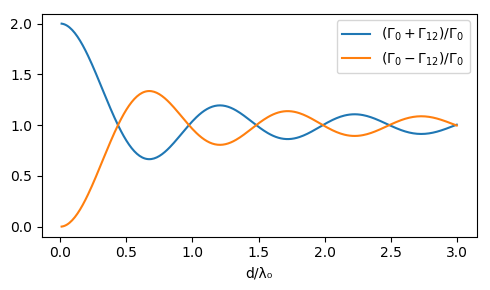

In [47]:
rates = [[],[]]
dspan = [0.01:0.01:3;]
d=0.1
for i = 1:length(dspan)
    pos = [[0.0,-dspan[i]/2,0.0],[0.0,dspan[i]/2,0.0]]
    Γ(i,j) = Gamma_ij(pos[i],pos[j],dips[1],dips[2],k0)
    push!(rates[1],1.0 + Γ(1,2))
    push!(rates[2],1.0 - Γ(1,2))
end

fig=figure(figsize=(5, 3))
plot(dspan,rates[1],label=L"(\Gamma_0 + \Gamma_{12})/\Gamma_0")
plot(dspan,rates[2],label=L"(\Gamma_0 - \Gamma_{12})/\Gamma_0")
legend()
xlabel("d/λ₀")
tight_layout()